In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

### Clean csv

In [2]:
df = pd.read_csv("imdb_movies.csv") #set dataframe

#get rid of columns such as orig_titlem budget_x, revenue, country
df.drop(df.columns[-6:], axis=1, inplace=True)
#get rid of date
df.drop(df.columns[1], axis=1, inplace=True)
df.head()

,names,score,genre,overview,crew
0,Creed III,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso..."
1,Avatar: The Way of Water,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt..."
2,The Super Mario Bros. Movie,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P..."
3,Mummies,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor..."
4,Supercell,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin..."


In [3]:
# Remove rows with any empty cells
df.dropna(inplace=True)
print(df['genre'].isna().sum())


0


### Preprocess data

In [4]:
nlp = spacy.load("en_core_web_sm")

#each word becomes token
def preprocess(text):
    tokens = [token.text.lower() for token in nlp(text)]
    
    #removes stopwords like ["the", "a", "and"]
    tokens = [token for token in tokens if token not in STOP_WORDS and token not in string.punctuation]
    
    #removes 'ing' like boxing became box
    lemma_tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    
    #put it into single string
    single_string = " ".join(lemma_tokens)
    
    return single_string

df['preprocessed_synopsis'] = df['overview'].apply(preprocess)
df['preprocessed_genre'] = df['genre'].apply(preprocess)
df.head()

,names,score,genre,overview,crew,preprocessed_synopsis,preprocessed_genre
0,Creed III,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",dominate box world adonis creed thrive career ...,drama action
1,Avatar: The Way of Water,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",set decade event film learn story sully family...,science fiction adventure action
2,The Super Mario Bros. Movie,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",work underground fix water main brooklyn plumb...,animation adventure family fantasy ...
3,Mummies,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",series unfortunate event mummy end present day...,animation comedy family adventure ...
4,Supercell,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",good hearted teenager william live hope follow...,action


### Tokenize words

In [5]:
# Tfidf object
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['preprocessed_synopsis'])

### Silhouette Score

<function matplotlib.pyplot.show(close=None, block=None)>

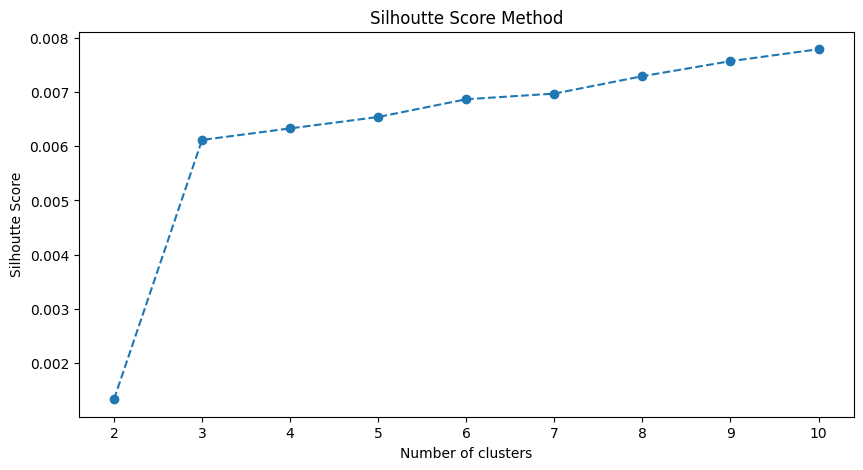

In [8]:
silhouette_scores = []
for i in range(2, 11): #Testing 2 to 10clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10,5))
plt.plot(range(2,11), silhouette_scores, marker='o',linestyle='--')
plt.title('Silhoutte Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte Score')
plt.xticks(range(2,11))
plt.show

### KMeans

In [9]:
# Kmeans object
kmeans = KMeans(n_clusters=4)  # Try diff n_clusters
kmeans.fit(tfidf_matrix)

# Cluster for movies
df['cluster_label'] = kmeans.labels_

### PCA PLOT

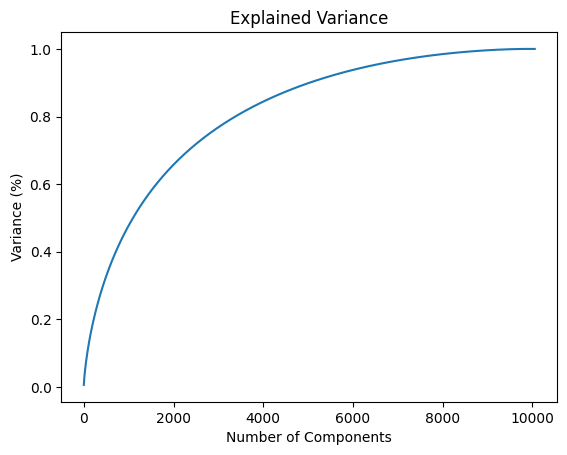

In [10]:
pca = PCA().fit(tfidf_matrix.toarray())

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

### PCA

In [11]:
# reduce dimension
pca = PCA(n_components=3000) #change n_components
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

### LDA

In [12]:
lda = LDA(n_components=10)  # change n_components to see
lda.fit(tfidf_matrix)

LatentDirichletAllocation()

### Movie Recommender Function

In [13]:
def recommend_movies(keyword):
    # Clean up input
    keyword = preprocess(keyword)
    
    # Tokenize w/ tfidf
    keyword_vector = vectorizer.transform([keyword])
    
    # Predict cluster
    cluster = kmeans.predict(keyword_vector)[0]
    cluster_movies = df[df['cluster_label'] == cluster] #['names']
    
    cosine_similarities = cosine_similarity(keyword_vector, tfidf_matrix).flatten()
    
    top_five = cosine_similarities.argsort()[:-6:-1] #top 5 movies
    recommended_movies = df.iloc[top_five][['names', 'score', 'genre', 'overview']] #make sure to add genre scores synopsis
    
    return recommended_movies



In [14]:
recommend_movies('student')

,names,score,genre,overview
3553,The Perilous Internet Ring,70.0,"Horror, Thriller",A college student investigates a series of mys...
6832,Lemonade Mouth,75.0,"Drama, Comedy, TV Movie",After five disparate high school students meet...
10091,Love Match,53.0,"Romance, Comedy",A sexy comedy about a professor and his female...
9860,Re-Animator,70.0,"Science Fiction, Comedy, Horror",A dedicated student at a medical college and h...
3304,High School Lynching,30.0,Crime,A high school student is captured and sexually...


### Evaluation

In [15]:
def evaluate_recommendation_system(query, ground_truth, recommend_function, k=5):
    """
    Evaluate the recommendation system for a given query using Precision@k and Recall@k.
    
    Parameters:
    - query: The query keyword used for generating recommendations.
    - ground_truth: A dictionary mapping queries to lists of relevant movie titles.
    - recommend_function: The function used to generate movie recommendations.
    - k: The number of top recommendations to consider for evaluation.
    
    Returns:
    - precision_k: Precision@k for the given query.
    - recall_k: Recall@k for the given query.
    """
    # Generate top-k recommendations for the query
    recommended_movies = recommend_function(query)
    recommended_titles = set(recommended_movies['names'].tolist())
    
    # Get the ground truth relevant movies for the query
    relevant_movies = set(ground_truth[query])
    
    # Calculate the number of relevant recommendations
    relevant_recommendations = recommended_titles.intersection(relevant_movies)
    num_relevant_recommendations = len(relevant_recommendations)
    
    # Calculate Precision@k and Recall@k
    precision_k = num_relevant_recommendations / k
    recall_k = num_relevant_recommendations / len(relevant_movies) if relevant_movies else 0
    
    return precision_k, recall_k

# Example usage:
ground_truth = {
     'student': ['The Perilous Internet Ring', 'Lemonade Mouth', 'Love Match', 'Re-Animator', 'High School Lynching']  # Example ground truth  
}

query = 'student'
precision_k, recall_k = evaluate_recommendation_system(query, ground_truth, recommend_movies, k=5)
print(f"Precision@5: {precision_k}")
print(f"Recall@5: {recall_k}")


Precision@5: 1.0
Recall@5: 1.0


In [16]:
def evaluate_recommendation_system(query, ground_truth, recommend_function, k=5):
    """
    Evaluate the recommendation system for a given query using Precision@k and Recall@k.
    
    Parameters:
    - query: The query keyword used for generating recommendations.
    - ground_truth: A dictionary mapping queries to lists of relevant movie titles.
    - recommend_function: The function used to generate movie recommendations.
    - k: The number of top recommendations to consider for evaluation.
    
    Returns:
    - precision_k: Precision@k for the given query.
    - recall_k: Recall@k for the given query.
    """
    # Generate top-k recommendations for the query
    recommended_movies = recommend_function(query)
    recommended_titles = set(recommended_movies['names'].tolist())
    
    # Get the ground truth relevant movies for the query
    relevant_movies = set(ground_truth[query])
    
    # Calculate the number of relevant recommendations
    relevant_recommendations = recommended_titles.intersection(relevant_movies)
    num_relevant_recommendations = len(relevant_recommendations)
    
    # Calculate Precision@k and Recall@k
    precision_k = num_relevant_recommendations / k
    recall_k = num_relevant_recommendations / len(relevant_movies) if relevant_movies else 0
    
    return precision_k, recall_k

# Example usage:
ground_truth = {
    # 'basketball': ['Above the Rim', 'The Way Back', 'He Got Game', 'Kuroko\'s Basketball the Movie: Last Game', 'Triple Standard']  # Example ground truth
     #'hacker': ['Criminal', 'Cazadora', 'The Passion of the Christ', 'Murder Mystery 2', 'Bandit']  # Example ground truth
    'student': ['Hex', 'Cazadora', 'Above the Rim', 'Tetris', 'Spider-Man: No Way Home']  # Example ground truth
}

query = 'student'
precision_k, recall_k = evaluate_recommendation_system(query, ground_truth, recommend_movies, k=5)
print(f"Precision@5: {precision_k}")
print(f"Recall@5: {recall_k}")


Precision@5: 0.0
Recall@5: 0.0
